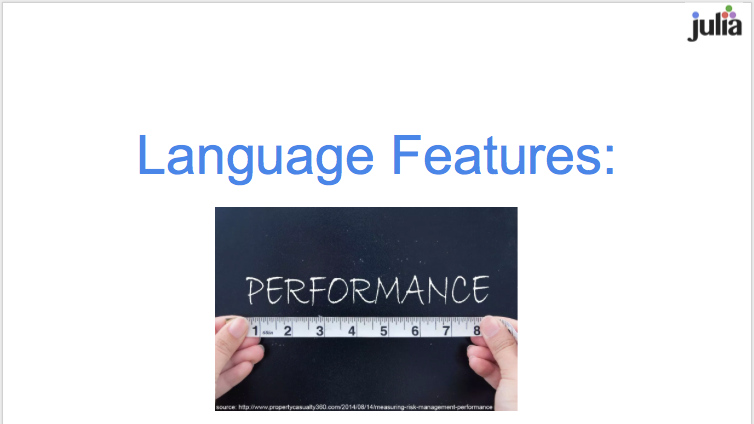

In [1]:
using FileIO   # Let's us load some figures into cells
img = load("juliaTalk_perform_fig.png")

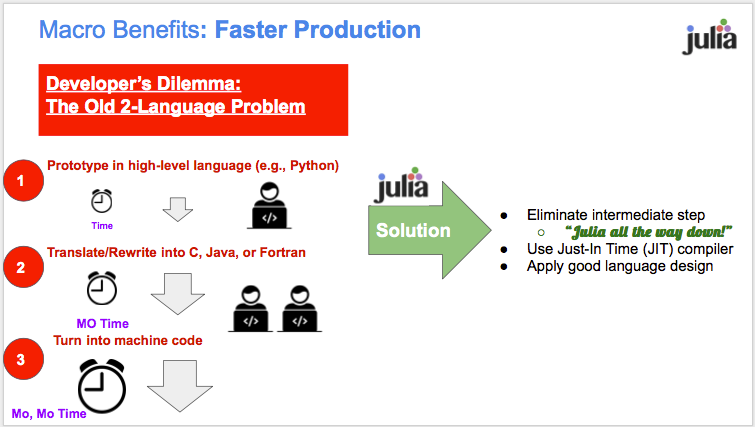

In [2]:
img = load("juliaTalk_perform2_fig.png")

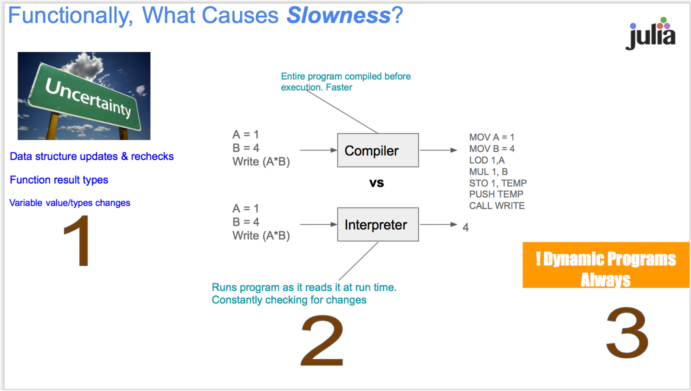

In [3]:
img = load("juliaTalk_perform3_fig.png")

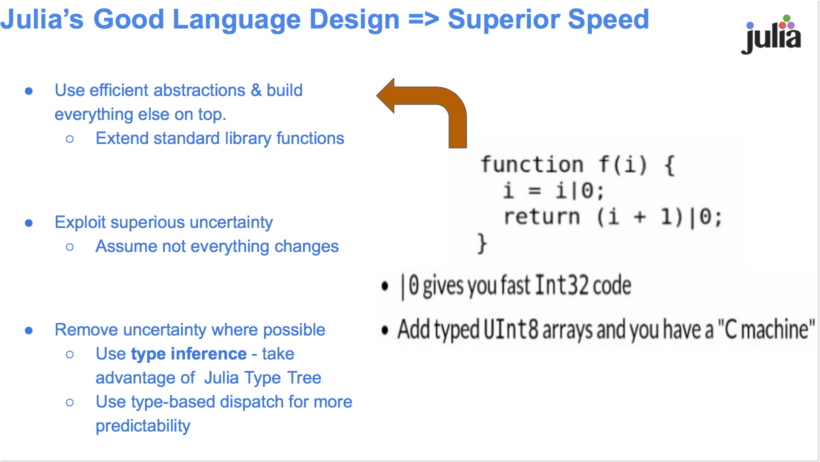

In [4]:
img = load("juliaTalk_perform4_fig.png")

## Julia is a High level language that runs like a low-level language

# So, How Does Julia Get Its Speed?
## Answer: Using a Just In Time (JIT) compiler, Type Inference, and Multiple Dispatch



# Having a Look at The JIT

 Like Python, Julia is an `intrepreted` language , **BUT**, has the performance of a compiled `statically typed` language (e.g., C) thanks in part to a JIT-compiler Infrastructure based on Low Level Virtual Machine (LLVM).

Julia code is transformed by the LLVM library to machine code

During this transformation, LLVM takes advantage of `type stability` (where possible) through specialization via **multiple dispatch** which makes it easy to compile to efficient code. 

$^* _{reference: http://www.stochasticlifestyle.com/like-julia-scales-productive-insights-julia-developer/}$

In [ ]:
using FileIO   # Let's us load some figures into cells
img = load("juliaTalk_jit_fig.png")

# Here is how it works 

When a function is called, Julia auto-specializes it down to concrete types (e.g., Float64)

In [ ]:
img = load("juliaTalk_concrete_fig.png")

In [ ]:
# Sample function with Abstract Type Number - 
#    - hint for the compiler to know I can exclude huge branches of the type tree 
#    - but inputs are expected to be concrete types that are directly or indirectly linked to Number

function f(x::Number)
    x^2
end

In [ ]:
#Specialze to Float64 concreate type when you call it with f(1.0)
f(1.0)

## So back at the JIT

* using the type information, it has a compile-time stage where it propagates all type information as far as it can go

    * basically, internally if you do `x^2`, it will replace that with `^(::Float64,2)` (where **2** is a compile-time constant)
* And then, since it can determine the types of everything, it will push this all the way down to generate clean *LLVM Intermediate Representation (IR) code* ,and thus clean assembly code for `x^2` on `Float64s`. 


In [ ]:
# Try a new float input
f(2.0)

Uses the same compiled code. Notice the compilation process **only** needs the type and not the runtime values!

In [ ]:
f(1)

Compiles a separate version for Integers (Int64)

### Cost of Using Just-In-Time Compiler (JIT)

* Compiler has to parse the source code and generate machine code before code can run
    * Means there is a noticeable start-up time for Julia programs the **first** time each function and macro runs in a session because the Julia libraries are written in Julia
    
* Doing things once is **memoization**
    * A memoized function remembers the results corresponding to some set of specific inputs. Subsequent calls with remembered inputs return the remembered result rather than recalculating. 

In [ ]:
@time rand(10^6); # bot the @time macro and the rand() function need to be compiled the first time through the code

In [ ]:
@time rand(10^6); # second times is order of magnitudes less

## Julia's Compilation Process Is Deterministic and Is Open to Introspection (i.e.,  Review and Optimization)


We reveal the Interprocedural Optimization (IPO) for how the JIT compiler works.  

In [ ]:
#to See the optimized Abstract Syntax Tree (AST)
code_typed(f(1.0))

## The Abstract Syntax Tree

tree representation of the abstract syntactic structure of soucre code written in the Julia Programming Language. Represents the structure of the code.


In [ ]:
# Shows the precompiled modules and the Abstract Syntax Tree (AST) 
#Explicitly highlights which variables are being dynamic and what to optimize


@code_warntype f(1.0) # Tells how well the compiler has inferred the types  - Especially return values

In [ ]:
# The LLVM IR for review and possible low-level code Optimization
@code_llvm f(1.0)

###  By LLVM IR optimization, we mean 
Say we have code that does

X - X        --------> 0

X + 0        --------> X

Using the above we can just do simplification for the bottom

(X * 2) - X  -------> X

(X + (X -X)) -------> X

(X + 0)      -------> X






## OR  ( Resolving type instability as in the example below)

For example, seeing how the code *below* shows a `x` start as one type, `Int64` and then `Int64 + Float64`

Here in this code snippet where `g(1.0, 1.0)`

```
function g(a,n)
  x = 0
  for i in 1:n
    x += a
  end
end
```

We could use `@code_warntype` to reveal the inconsistent usage (see `Line 25 below`)

```
Variables:
  #self#::#g
  a::Float64
  n::Int64
  i::Int64
  #temp#@_5::Int64
  x::UNION{FLOAT64, INT64}
  #temp#@_7::Core.MethodInstance
  #temp#@_8::Float64
 
Body:
  begin
      x::UNION{FLOAT64, INT64} = 0 # line 3:
      SSAValue(2) = (Base.select_value)((Base.sle_int)(1, n::Int64)::Bool, n::Int64, (Base.sub_int)(1, 1)::Int64)::Int64
      #temp#@_5::Int64 = 1
      5:
      unless (Base.not_int)((#temp#@_5::Int64 === (Base.add_int)(SSAValue(2), 1)::Int64)::Bool)::Bool goto 29
      SSAValue(3) = #temp#@_5::Int64
      SSAValue(4) = (Base.add_int)(#temp#@_5::Int64, 1)::Int64
      #temp#@_5::Int64 = SSAValue(4) # line 4:
      unless (x::UNION{FLOAT64, INT64} isa Int64)::Bool goto 14
      #temp#@_7::Core.MethodInstance = MethodInstance for +(::Int64, ::Float64)
      goto 23
      14:
      unless (x::UNION{FLOAT64, INT64} isa Float64)::Bool goto 18
      #temp#@_7::Core.MethodInstance = MethodInstance for +(::Float64, ::Float64)
      goto 23
      18:
      goto 20
      20:
      #temp#@_8::Float64 = (x::UNION{FLOAT64, INT64} + a::Float64)::Float64
      goto 25
      23:
      #temp#@_8::Float64 = $(Expr(:invoke, :(#temp#@_7), :(Main.+), :(x), :(a)))
      25:
      x::UNION{FLOAT64, INT64} = #temp#@_8::Float64
      27:
      goto 5
      29:
      return
  end::Void
```



and fix it the code by

`g(1.0, 1.0)`

```
function g(a,n)
  x = zero(a)
  for i in 1:n
    x += a
  end
end
```

In [ ]:
function g(a,n)
  x = zero(a) # makes x Float64 type
  for i in 1:n
    x += a
  end
end

#@code_warntype g(1.0, 1.0)

In [ ]:
#Machine Code representation the static sytem image (.xo /.dll/.dylib)
@code_native f(1.0)

## The Take Aways

* The process is very clear and deterministic
* Easy to optimize your packages -- you can see what's going on
* Other languages are not so transparent -- trying doing this same thing with Matlab


In [ ]:
img = load("juliaTalk_majorkey_fig.png")